# LAB 04:  Advanced Feature Engineering in Keras 

**Learning Objectives**

1. Create temporal feature columns in Keras
2. Create geolocation feature columns with bucketization and feature crosses.
 

## Introduction 

In this notebook, we use Keras to build a taxi fare price prediction model and utilize feature engineering to improve the fare amount prediction for NYC taxi cab rides. 

Each learning objective will correspond to a __#TODO__ in this student lab notebook 

Start by importing the necessary libraries for this lab.

In [111]:
import os
import math
import shutil
import numpy as np
import datetime
import logging

# SET TF ERROR LOG VERBOSITY
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense,
    DenseFeatures,
    Input,
    Lambda,
)


print(tf.version.VERSION)

2.0.0


Next, we initialize model parameters.

In [112]:
DATADIR = '../data'
NBUCKETS = 10  # for feature crossing
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 59126  * 5 # remember the training dataset repeats, so this will wrap around
NUM_EVALS = 5  # evaluate this many times
NUM_EVAL_EXAMPLES = 17000  # enough to get a reasonable sample, but no so much that it slows down

The Taxi Fare dataset for this lab is 106,545 rows and has been pre-processed and split for use in this lab.  Note that the dataset is same as used in the Big Query feature engineering labs.  The fare_amount is the target, the continuous value we’ll train a model to predict.  

First, let's download the  .csv data by copying the data from a cloud storage bucket.

In [113]:
!gsutil cp gs://cloud-training-demos/feat_eng/data/*.csv .

Copying gs://cloud-training-demos/feat_eng/data/taxi-test.csv...
Copying gs://cloud-training-demos/feat_eng/data/taxi-train.csv...               
Copying gs://cloud-training-demos/feat_eng/data/taxi-valid.csv...               
/ [3 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 3 objects/5.3 MiB.                                      


Let's move the .csv data by moving the files into the "data" directory.

In [ ]:
shutil.move('taxi-train.csv','data')
shutil.move('taxi-test.csv','data')
shutil.move('taxi-valid.csv','data')

#### Note:  Ensure that all three files have been copied to the home directory in the left panel.

## Create an input pipeline 

Typically, you will use a two step proces to build the pipeline. Step one is to define our columns of data, which column we're predicting for, and the default values.  Step 2 is to define two functions - a function to define the features and label you want to use and a function to load the training data.  Also, note that pickup_datetime is a string and we will need to handle this in our feature engineered model.  


In [120]:
CSV_COLUMNS = [
        'fare_amount',
        'pickup_datetime',
        'pickup_longitude',
        'pickup_latitude',
        'dropoff_longitude',
        'dropoff_latitude',
        'passenger_count',
        'key',
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
DAYS = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

In [121]:
# A function to define features and labesl
def features_and_labels(row_data):
    for unwanted_col in ['key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label

# # A utility method to create a tf.data dataset from a Pandas Dataframe
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels)  # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
        dataset = dataset.prefetch(1)  # take advantage of multi-threading; 1=AUTOTUNE
  return dataset



## Create a Baseline DNN Model in Keras

Now let's build the Deep Neural Network (DNN) model in Keras using the functional API. Unlike the sequential API, we will need to specify the input and hidden layers.  Note that we are creating a linear regression baseline model with no feature engineering. Recall that a baseline model is a solution to a problem without applying any machine learning techniques.

In [122]:
# Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):  # Root mean square error
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_dnn_model():  # Build the DNN model
    NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                    'dropoff_longitude', 'dropoff_latitude',
                    'passenger_count']

# input layer
    inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

# feature_columns
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in NUMERIC_COLS
    }

# Constructor for DenseFeatures takes a list of numeric columns
# The Functional API in Keras requires you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

# two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

# final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)

# compile model
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model


model = build_dnn_model()

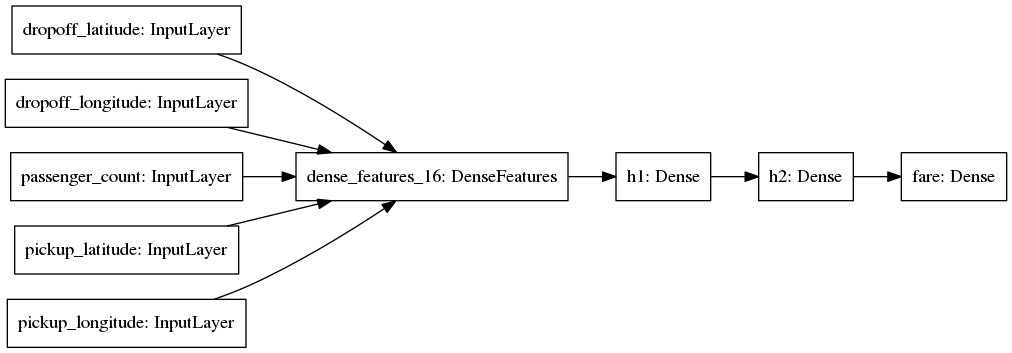

In [123]:
# Here is our baseline DNN architecture
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

## Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit).  Note that we should really use many more NUM_TRAIN_EXAMPLES (i.e. a larger dataset). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

Note:  Ensure that a directory called "data" exists and includes the taxi-train, taxi-test, and taxi-valid .csv files.

In [124]:
trainds = load_dataset('data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Train for 1847 steps, validate for 17 steps
Epoch 1/5
1847/1847 [==============================] - 6s 3ms/step - loss: 107.1691 - rmse: 9.6789 - mse: 107.1690 - val_loss: 99.7944 - val_rmse: 9.9720 - val_mse: 99.7944
Epoch 2/5
1847/1847 [==============================] - 5s 3ms/step - loss: 100.7454 - rmse: 9.4778 - mse: 100.7455 - val_loss: 99.7556 - val_rmse: 9.9700 - val_mse: 99.7556
Epoch 3/5
1847/1847 [==============================] - 5s 3ms/step - loss: 103.8987 - rmse: 9.6472 - mse: 103.8987 - val_loss: 100.1907 - val_rmse: 9.9905 - val_mse: 100.1907
Epoch 4/5
1847/1847 [==============================] - 5s 3ms/step - loss: 102.3225 - rmse: 9.5446 - mse: 102.3224 - val_loss: 99.6977 - val_rmse: 9.9670 - val_mse: 99.6977
Epoch 5/5
1847/1847 [==============================] - 5s 3ms/step - loss: 103.7711 - rmse: 9.5858 - mse: 103.7710 - val_loss: 100.0607 - val_rmse: 9.9841 - val_mse: 100.0607


#### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.  A line plot is also created showing the mean squared error loss over the training epochs for both the train (blue) and test (orange) sets.

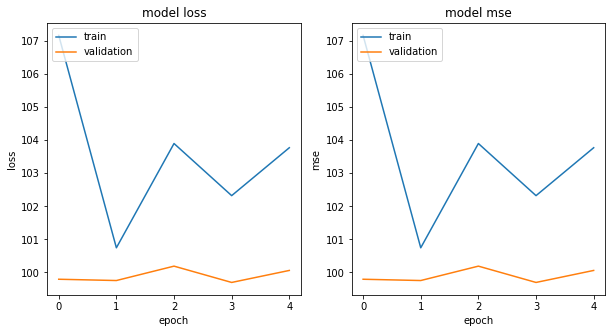

In [125]:
# Plot

import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'mse']):  
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

#### Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.  Next we note the fare price at this geolocation and pickup_datetime.

In [126]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'pickup_datetime': tf.convert_to_tensor(['2010-02-08 09:17:00 UTC'], dtype=tf.string),
}, steps=1)

array([[11.00871]], dtype=float32)

## Improve Model Performance Using Feature Engineering 

We now improve our model's performance by creating the following feature engineering types:  Temporal, Categorical, and Geolocation. 

#### Temporal Feature Columns

We incorporate the temporal feature pickup_datetime.  As noted earlier, pickup_datetime is a string and we will need to handle this within the model.  First, you will include the pickup_datetime as a feature and then you will need to modify the model to handle our string feature.

#### Geolocation/Coordinate Feature Columns

The pick-up and drop-off longitude and latitude data are crucial to predicting the fare amount as fare amounts in NYC taxis are largely determined by the distance traveled. As such, we need to teach the model the Euclidean distance between the pick-up and drop-off points.

Recall that latitude and longitude allows us to specify any location on Earth using a set of coordinates. In our training data set, we restricted our data points to only pickups and drop offs within NYC. New York city has an approximate longitude range of -74.05 to -73.75 and a latitude range of 40.63 to 40.85.

The dataset contains information regarding the pickup and drop off coordinates. However, there is no information regarding the distance between the pickup and drop off points. Therefore, we create a new feature that calculates the distance between each pair of pickup and drop off points. We can do this using the Euclidean Distance, which is the straight-line distance between any two coordinate points.

We now create two new "geo" function for our model.  We create a function called "euclidean" to initialize our geolocation parameters.  We then create a function called transform.   The transform function passes our numerical and string columns features as inputs to the model, scales geolocation features, then creates the Euclian distance as a transformed variable with the geolocation features. Lastly, we bucketize the latitude and longitude features.

In [136]:
# Add transformations
# TODO 1
def parse_datetime(s):
    if type(s) is not str:
        s = s.numpy().decode('utf-8')
    return datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S %Z")

# TODO 1
def get_dayofweek(s):
    ts = parse_datetime(s)
    return DAYS[ts.weekday()]

# TODO 1
@tf.function
def dayofweek(ts_in):
    return tf.map_fn(
        lambda s: tf.py_function(get_dayofweek, inp=[s], Tout=tf.string),
        ts_in
    )

# TODO 2
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

@tf.function
def fare_thresh(x):
    return 60 * relu(x)


def transform(inputs, NUMERIC_COLS, STRING_COLS):
    print("BEFORE TRANSFORMATION")
    print("INPUTS:", inputs.keys())

    # Pass-through columns
    transformed = inputs.copy()
    del transformed['pickup_datetime']

    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in NUMERIC_COLS
    }

  
         # Scaling longitude from range [-70, -78] to [0, 1]
    if True:
        for lon_col in ['pickup_longitude', 'dropoff_longitude']:  # in range -70 to -78
            transformed[lon_col] = tf.keras.layers.Lambda(
                lambda x: (x+78)/8.0,
                name='scale_{}'.format(lon_col)
            )(inputs[lon_col])
            
        # Scaling latitude from range [37, 45] to [0, 1]
        for lat_col in ['pickup_latitude', 'dropoff_latitude']:  # in range 37 to 45
            transformed[lat_col] = tf.keras.layers.Lambda(
                lambda x: (x-37)/8.0,
                name='scale_{}'.format(lat_col)
            )(inputs[lat_col])
# TODO 2
    # add Euclidean distance. Doesn't have to be accurate calculation because NN will calibrate it
    if True:
        transformed['euclidean'] = tf.keras.layers.Lambda(euclidean, name='euclidean')([
            inputs['pickup_longitude'],
            inputs['pickup_latitude'],
            inputs['dropoff_longitude'],
            inputs['dropoff_latitude']
        ])
        feature_columns['euclidean'] = tf.feature_column.numeric_column('euclidean')
# TODO 2
    if True:
        # https://buganizer.corp.google.com/issues/135479527
        # featurecross lat, lon into nxn buckets, then embed
        nbuckets = NBUCKETS
        latbuckets = np.linspace(0, 1, nbuckets).tolist()
        lonbuckets = np.linspace(0, 1, nbuckets).tolist()
        b_plat = tf.feature_column.bucketized_column(feature_columns['pickup_latitude'], latbuckets)
        b_dlat = tf.feature_column.bucketized_column(feature_columns['dropoff_latitude'], latbuckets)
        b_plon = tf.feature_column.bucketized_column(feature_columns['pickup_longitude'], lonbuckets)
        b_dlon = tf.feature_column.bucketized_column(feature_columns['dropoff_longitude'], lonbuckets)
        ploc = tf.feature_column.crossed_column([b_plat, b_plon], nbuckets * nbuckets)
        dloc = tf.feature_column.crossed_column([b_dlat, b_dlon], nbuckets * nbuckets)
        pd_pair = tf.feature_column.crossed_column([ploc, dloc], nbuckets ** 4)
        feature_columns['pickup_and_dropoff'] = tf.feature_column.embedding_column(pd_pair, 100)

    
    return transformed, feature_columns
    print("AFTER TRANSFORMATION")
    print("TRANSFORMED:", transformed.keys())
    print("FEATURES", feature_columns.keys())
    return transformed, feature_columns

In [137]:
# DNN MODEL
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


def build_dnn_model():
    # input layer is all float except for pickup_datetime which is a string
    STRING_COLS = ['pickup_datetime']
    NUMERIC_COLS = set(CSV_COLUMNS) - set([LABEL_COLUMN, 'key']) - set(STRING_COLS)
    print(STRING_COLS)
    print(NUMERIC_COLS)
    inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }
    inputs.update({
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype='string')
        for colname in STRING_COLS
    })

# transforms
    transformed, feature_columns = transform(inputs, NUMERIC_COLS, STRING_COLS)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(transformed)

# two hidden layers of [32, 8] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation='relu', name='h2')(h1)

# final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='fare')(h2)
    model = tf.keras.models.Model(inputs, output)

# Compile model
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our DNN architecture so far:\n")
model = build_dnn_model()
#print(model.summary())


Here is our DNN architecture so far:

['pickup_datetime']
{'dropoff_longitude', 'pickup_longitude', 'dropoff_latitude', 'pickup_latitude', 'passenger_count'}
BEFORE TRANSFORMATION
INPUTS: dict_keys(['dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_latitude', 'pickup_longitude', 'pickup_datetime'])


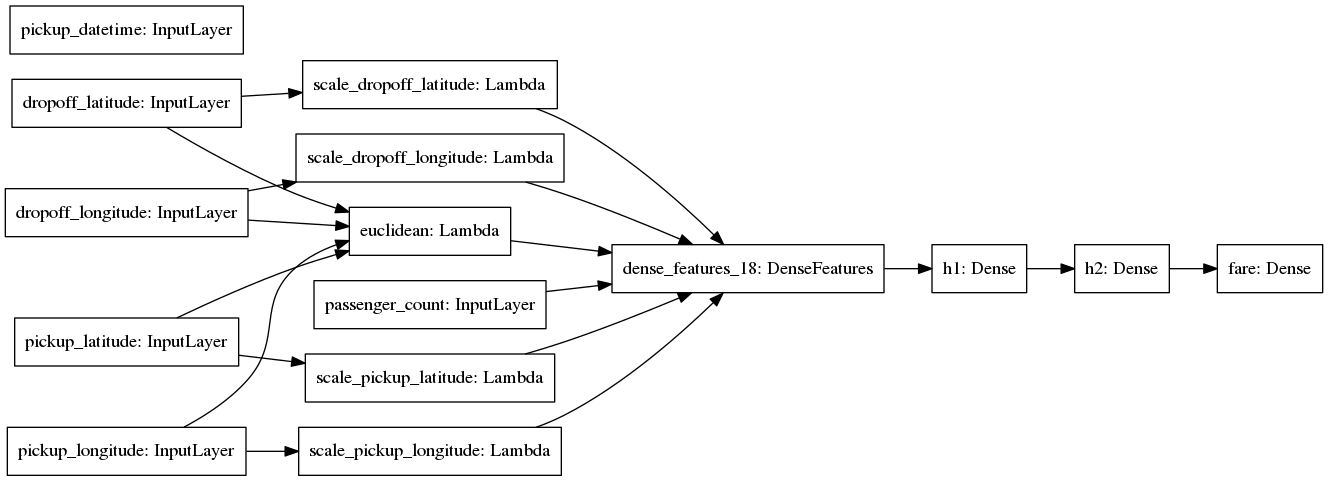

In [138]:
# Here is our baseline DNN architecture
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

In [ ]:
trainds = load_dataset('data/taxi-train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('data/taxi-valid*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Train for 1847 steps, validate for 17 steps
Epoch 1/5
1847/1847 [==============================] - 24s 13ms/step - loss: 100.2442 - rmse: 9.4206 - mse: 100.2442 - val_loss: 85.3926 - val_rmse: 9.2220 - val_mse: 85.3926
Epoch 2/5
1847/1847 [==============================] - 22s 12ms/step - loss: 52.9304 - rmse: 6.4919 - mse: 52.9303 - val_loss: 27.6732 - val_rmse: 5.2203 - val_mse: 27.6732
Epoch 3/5
1847/1847 [==============================] - 22s 12ms/step - loss: 27.0336 - rmse: 4.3748 - mse: 27.0336 - val_loss: 25.0255 - val_rmse: 4.9652 - val_mse: 25.0255
Epoch 4/5
1845/1847 [============================>.] - ETA: 0s - loss: 27.0311 - rmse: 4.3070 - mse: 27.0311

#### Visualize the DNN model layers

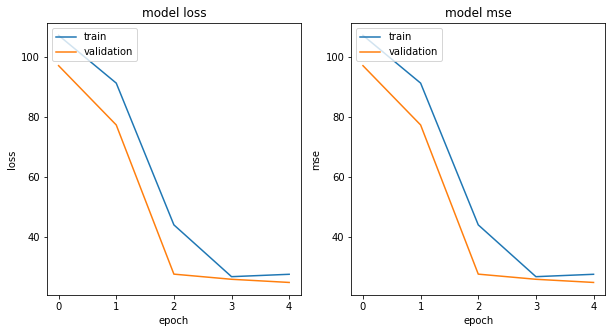

In [131]:
# Plot

import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'mse']):  
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

Next we note the fare price at this geolocation and pickup_datetime and compare it to the base model.


In [132]:
model.predict({
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'pickup_datetime': tf.convert_to_tensor(['2010-02-08 09:17:00 UTC'], dtype=tf.string),
}, steps=1)

array([[7.0454063]], dtype=float32)

####  Markdown table generator:  http://www.tablesgenerator.com/markdown_tables
Create a RMSE summary table:

| Model              | Taxi Fare | Description                               |
|--------------------|-----------|-------------------------------------------|
| Baseline           | 11.00     | --Baseline model - no feature engineering |
| Feature Engineered | 7.040      | --Feature Engineered Model                |

Plot a bar chart.

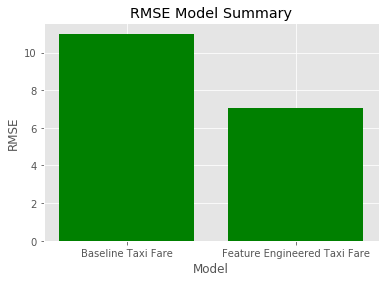

In [135]:
# Plot

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['Baseline Taxi Fare', 'Feature Engineered Taxi Fare']
RMSE = [11.00, 7.040]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, RMSE, color='green')
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("RMSE Model Summary")

plt.xticks(x_pos, x)

plt.show()

Copyright 2020 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.